###### 문제 정의

* 목표: 저위험 중수익 전략수립(Calendar Spread)
* 전략방향
  - 스프레드 확대(축소전망) => 고평가 선물 매도, 저평가 선물 매수
  - 스프레드 축소 => 포지션 청산
* 전제조건: 매수포지션 증거금 100%, 매도포지션 증거금 100%
* 주의사항: 당분기물 결제시점에는 포지션 청산

In [213]:
## 기본
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import datetime as dt

In [214]:
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (13,7)

## Data

In [215]:
df_ori = pd.read_csv('data/test_bitmex_1h.csv')
df_ori['time'] = pd.to_datetime(df_ori['time'])

In [216]:
df_ori.columns
## "coin" 컬럼 불필요 / 'time' timestamp 1시간 단위

Index(['coin', 'symbol', 'time', 'vwap', 'volume'], dtype='object')

In [217]:
df_ori['symbol'].unique()
## 시간순으로 정렬됨

array(['XBTH18', 'XBTM18', 'XBTU18', 'XBTZ18', 'XBTH19', 'XBTM19',
       'XBTU19', 'XBTZ19', 'XBTH20', 'XBTM20', 'XBTU20', 'XBTZ20'],
      dtype=object)

### 구조변환

In [218]:
dfs = [df_ori[df_ori['symbol'] == symbol].set_index('time')[['vwap', 'volume']] 
       for symbol in df_ori['symbol'].unique()]
df_ls = []
for i in range(len(dfs)-1):
    temp = pd.concat([dfs[i], dfs[i+1]], axis=1).dropna()
    temp.columns = ['vwap_near', 'volume_near', 'vwap_longer', 'volume_longer']
    ## 스프레드
    temp['spread'] = temp['vwap_longer'] - temp['vwap_near']
    ## 만기까지 남은 시간
    temp['duetime'] = ((temp.index[-1] - temp.index).astype(int)/1000000000)/(60*60)
    temp['epi_no'] = i + 1
    temp = temp[['vwap_near', 'vwap_longer', 'volume_near', 'volume_longer', 'duetime', 'spread', 'epi_no']]
    df_ls.append(temp)
    
df_res = pd.concat(df_ls)

<AxesSubplot:xlabel='time'>

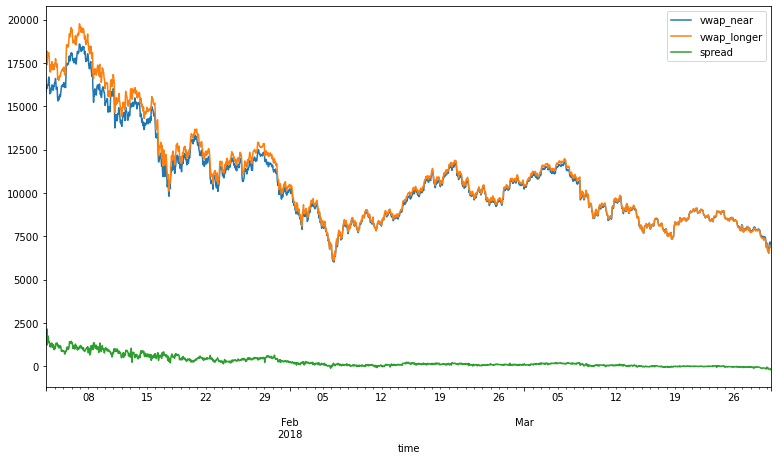

In [219]:
## 에피소드 1
test = df_res[df_res['epi_no'] == 1].copy()
test[['vwap_near', 'vwap_longer', 'spread']].plot()

### 기본 전처리

In [220]:
df_res.info()
## 결측없음

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26146 entries, 2018-01-02 23:00:00 to 2020-09-24 15:00:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vwap_near      26146 non-null  float64
 1   vwap_longer    26146 non-null  float64
 2   volume_near    26146 non-null  float64
 3   volume_longer  26146 non-null  float64
 4   duetime        26146 non-null  float64
 5   spread         26146 non-null  float64
 6   epi_no         26146 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 1.6 MB


In [221]:
df_res.describe()

,vwap_near,vwap_longer,volume_near,volume_longer,duetime,spread,epi_no
count,26146.000000,26146.000000,2.614600e+04,2.614600e+04,26146.000000,26146.000000,26146.000000
mean,7865.374416,7937.936299,2.328524e+06,1.397782e+06,1195.703664,72.561883,6.162052
std,2530.356441,2632.035674,3.409824e+06,2.831472e+06,697.257780,136.737249,3.109516
min,3111.727976,3055.766457,1.000000e+01,1.000000e+00,0.000000,-488.570283,1.000000
25%,6364.331803,6362.389815,5.492800e+05,2.992785e+05,595.000000,-2.167776,4.000000
50%,7976.239272,8023.032100,1.283954e+06,7.165525e+05,1189.000000,39.336709,6.000000
75%,9571.311648,9660.829739,2.817488e+06,1.573968e+06,1784.000000,115.686773,9.000000
max,18588.599072,19755.991317,1.241662e+08,1.921235e+08,2524.000000,2167.928978,11.000000


<AxesSubplot:xlabel='time'>

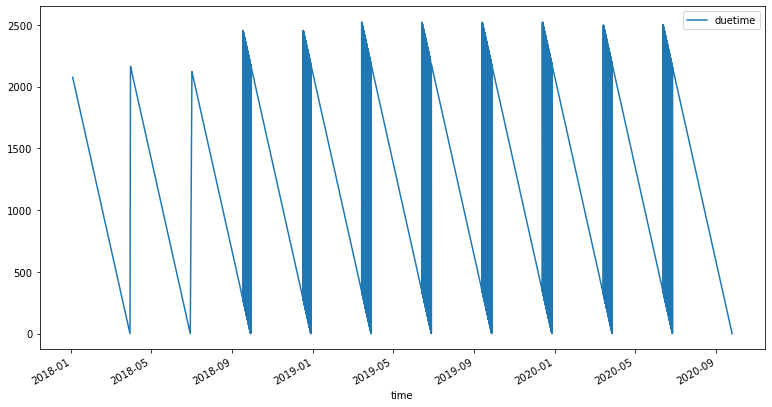

In [222]:
df_res[['duetime']].plot()
## 에피소드가 겹치는 구간이 있음

In [233]:
df_ls_v2 = [df_ls[0].copy()]
for i in range(len(df_ls)-1):
    df_ls_v2.append(df_ls[i+1][df_ls[i+1].index > df_ls[i].index[-1]])
    
df_res_v2 = pd.concat(df_ls_v2)
## 일관된 시계열에 대한 백테스트가 제한적
## 당분기물 결재일 이전 겹치는 구간은 중복 제거

<AxesSubplot:xlabel='time'>

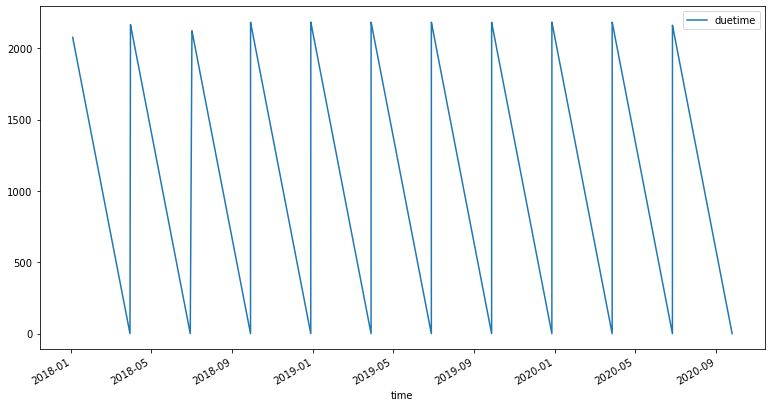

In [239]:
df_res_v2[['duetime']].plot()

<AxesSubplot:xlabel='time'>

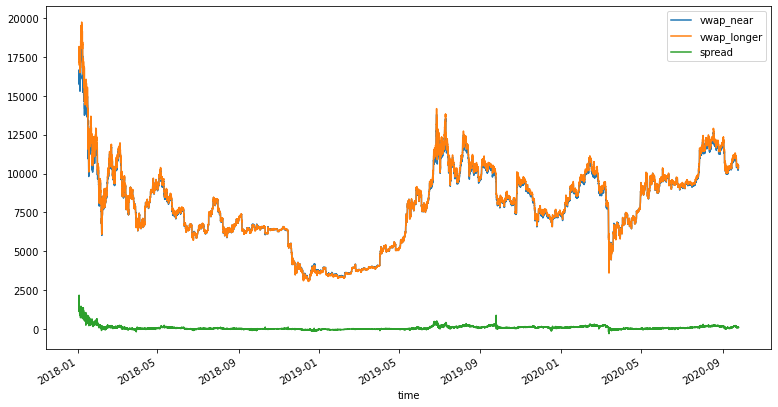

In [240]:
df_res_v2[['vwap_near', 'vwap_longer', 'spread']].plot()

<AxesSubplot:xlabel='time'>

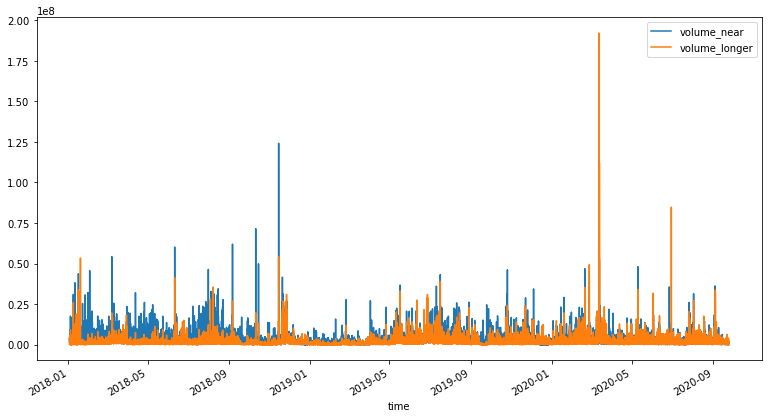

In [241]:
df_res_v2[['volume_near', 'volume_longer']].plot()
## 급락으로 인한 거래량 상승이 관찰됨
## 오입력은 아닌 것으로 판단됨

## Save

In [242]:
df_res_v2.to_csv('data/data_prep.csv')